Dataset Loaded
Samples: 569
Total Features: 30

Baseline AUC (All Features): 0.9961

Using 2/3 Rule → Selecting top 20 features out of 30
AUC after retraining (2/3 features): 0.9953

AUC-Based Permutation Importance Ranking
    rank                  feature  auc_importance_mean  auc_importance_std
0      1            worst texture             0.008216            0.003045
1      2     worst concave points             0.006452            0.002684
2      3               area error             0.004874            0.002092
3      4               worst area             0.004804            0.002545
4      5          worst concavity             0.002996            0.001267
5      6             worst radius             0.002702            0.002055
6      7             mean texture             0.001621            0.000911
7      8          worst perimeter             0.001352            0.001397
8      9      mean concave points             0.001329            0.000916
9     10         worst smo

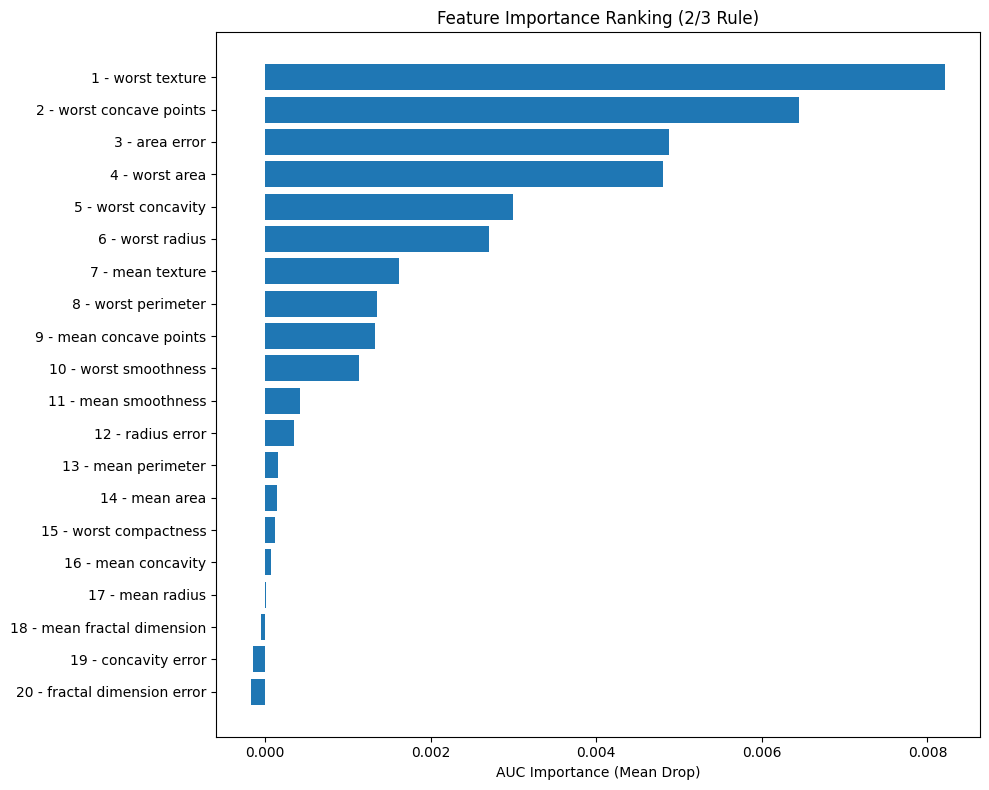


Pipeline Completed Successfully (2/3 Rule)


In [1]:
# ============================================
# XGBoost + AUC-based Permutation Importance
# Dynamic 2/3 Feature Selection Rule
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier


# ============================================
# 1. Load Dataset
# ============================================

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("======================================")
print("Dataset Loaded")
print("Samples:", X.shape[0])
print("Total Features:", X.shape[1])
print("======================================")


# ============================================
# 2. Train / Validation Split
# ============================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# ============================================
# 3. Train Initial XGBoost Model
# ============================================

model_full = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

model_full.fit(X_train, y_train)

baseline_auc = roc_auc_score(
    y_val,
    model_full.predict_proba(X_val)[:, 1]
)

print("\nBaseline AUC (All Features):", round(baseline_auc, 4))


# ============================================
# 4. Tree-based Ranking (GAIN)
# ============================================

booster = model_full.get_booster()
score_dict = booster.get_score(importance_type="gain")

tree_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": [score_dict.get(f, 0) for f in X.columns]
}).sort_values(
    by="importance",
    ascending=False
).reset_index(drop=True)


# ============================================
# 5. Dynamic 2/3 Feature Selection
# ============================================

total_features = X.shape[1]
k = int(np.ceil((2/3) * total_features))

selected_features = tree_importance.head(k)["feature"].tolist()

print(f"\nUsing 2/3 Rule → Selecting top {k} features out of {total_features}")


# ============================================
# 6. Retrain Model with Selected Features
# ============================================

model_selected = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

model_selected.fit(X_train[selected_features], y_train)

selected_auc = roc_auc_score(
    y_val,
    model_selected.predict_proba(X_val[selected_features])[:, 1]
)

print("AUC after retraining (2/3 features):", round(selected_auc, 4))


# ============================================
# 7. AUC-Based Permutation Importance
# ============================================

perm = permutation_importance(
    model_selected,
    X_val[selected_features],
    y_val,
    n_repeats=50,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": selected_features,
    "auc_importance_mean": perm.importances_mean,
    "auc_importance_std": perm.importances_std
}).sort_values(
    by="auc_importance_mean",
    ascending=False
).reset_index(drop=True)

importance_df["rank"] = importance_df.index + 1

importance_df = importance_df[[
    "rank",
    "feature",
    "auc_importance_mean",
    "auc_importance_std"
]]


# ============================================
# 8. Display Ranking
# ============================================

print("\n======================================")
print("AUC-Based Permutation Importance Ranking")
print("======================================")
print(importance_df)
print("\n\n")

# ============================================
# 9. Plot Importance
# ============================================

plt.figure(figsize=(10, 8))

labels = importance_df["rank"].astype(str) + " - " + importance_df["feature"]

plt.barh(labels, importance_df["auc_importance_mean"])
plt.xlabel("AUC Importance (Mean Drop)")
plt.title("Feature Importance Ranking (2/3 Rule)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nPipeline Completed Successfully (2/3 Rule)")
